In this document we&rsquo;ll work through a simple approach to estimating
Constant Frisch Elasticity (CFE) demand systems.

There are two prerequisites; the first is the `CFEDemands` python
module, which can be installed with a simple:



In [40]:
!pip install CFEDemands --upgrade
!pip install xarray
!pip install dvc
!pip install oauth2client

Requirement already up-to-date: CFEDemands in /opt/conda/lib/python3.8/site-packages (0.2.7)


The second prerequisite is a dataset including detailed information on
household expenditures and characteristics.  The structure of that
dataset is detailed in the next section.



## Data



Consider the case in which the data are saved in a google sheet; we&rsquo;ll
turn data from these into `pandas` dataframes.  
There are limits on the allowable size of google sheets (5 million
cells), so if your dataset is larger than this you&rsquo;ll need some other
mechanism to get your data into such dataframes.  Even in this latter
case you&rsquo;ll want your dataframes to have a structure that matches the
description given below.



### Structure of the Spreadsheet



An example spreadsheet can be found at
[https://docs.google.com/spreadsheets/d/13Ig5hZif-NSHtgkKRp_cEgKXk0lOsdUB2BAD6O_FnRo/](https://docs.google.com/spreadsheets/d/13Ig5hZif-NSHtgkKRp_cEgKXk0lOsdUB2BAD6O_FnRo/).

This spreadsheet consists of two worksheets, labeled &ldquo;Expenditures&rdquo;
and &ldquo;Household Characteristics&rdquo;, respectively.

Each worksheet has the initial three columns labeled &ldquo;j&rdquo;, &ldquo;t&rdquo;, and
&ldquo;m&rdquo;; together these identify an observation uniquely.  The column &ldquo;j&rdquo;
should include a household id; the column &ldquo;t&rdquo; should include an
indicator for the year or period (for those of you with
cross-sectional data these will all take a common value, e.g., 2019);
the column &ldquo;m&rdquo; should be an indicator of &ldquo;market&rdquo;, which may be a
region identifier, or may take a single value (e.g., &ldquo;Malawi&rdquo;).

The triple (j,t,m) will serve as the index of some constructed
dataframes.  It is important not to have **too** many different values
for &ldquo;m&rdquo; (unless you have lots of RAM to play with).

Beyond the first three columns, the &ldquo;Expenditures&rdquo; worksheet should
have one column for each category of expenditures (e.g., &ldquo;Rice&rdquo;, &ldquo;Goat
meat&rdquo;, &ldquo;Millet&rdquo;,&#x2026;).

Beyond the first three columns, the &ldquo;Household Characteristics&rdquo; should
have columns corresponding to different elements of the vector of
observable characteristics $z$.  If the data allow, I recommend
constructing observables that match what I have in the ICRISAT data:
namely numbers of &ldquo;Men&rdquo;, &ldquo;Women&rdquo;, &ldquo;Boys&rdquo; and &ldquo;Girls&rdquo;; also the
logarithm of total household size (&ldquo;log HSize&rdquo;).



### From Sheet to DataFrame to Result Object



We begin by defining a dictionary that contains the spreadsheet key. 
Here is our spreadsheet for people in Uganda



In [41]:
Uganda_Data = '1mZcHvSD55wGCicdqxbEnioE3AOXM_pVb6zVwHhtBzSk'

With the spreadsheet defined , grab it and define a couple of
dataframes. Note that the spreadsheet must be public for this approach
to work; if you want to keep this private consider using private
keys.



In [42]:
import pandas as pd
import numpy as np
import sys
sys.path.append('../Project2/')
from eep153_tools import read_sheets


#### Need private keys from json file (we're authenticating using "service accounts")
!gpg --batch --passphrase "noodle octopus" -d ../students-9093fa174318.json.gpg > ../students-9093fa174318.json
####

# Add credentials if sheet not meant to be public
x = read_sheets(Uganda_Data,sheet='Expenditures',json_creds='../students-9093fa174318.json')
                 
# Change 'ICRISAT' to key of your own sheet in Sheets, above
z = read_sheets(Uganda_Data,sheet="HH Characteristics",json_creds='../students-9093fa174318.json')

# Assume a single market: (Comment this out to make each village its own market)
z['m'] = 1
x['m'] = 1

x = x.replace("NaN",np.nan) # Replace zeros with missing
x = x.replace("0",np.nan)
x = x.apply(lambda x: pd.to_numeric(x,errors='coerce'))

# Take logs of expenditures; call this y
y = np.log(x.set_index(['j','t','m']))

z.set_index(['j','t','m'],inplace=True)

gpg: AES256 encrypted data
gpg: encrypted with 1 passphrase


This gives a dataframe of household characteristics $z$ with a simple structure.



In [43]:
z.head()

,,,M 0-3,M 4-8,M 9-13,M 14-18,M 19-30,M 31-50,M 51+,F 0-3,F 4-8,F 9-13,F 14-18,F 19-30,F 31-50,F 51+
j,t,m,,,,,,,,,,,,,,
1013000201,2005,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1013000202,2005,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0
1013000204,2005,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1013000206,2005,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1013000209,2005,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [44]:
z["Family Size"] = np.log(z["M 0-3"] + z["M 4-8"] + z["M 9-13"] + z["M 14-18"] + z["M 19-30"] + z["M 31-50"]+ z["M 51+"] + z["F 0-3"] + z["F 4-8"] + z["F 9-13"] + z["F 14-18"] + z["F 19-30"] + z["F 31-50"]+ z["F 51+"])
z = z.loc[np.isfinite(z['Family Size'])]
z
# some households have no people, get rid of those
# error should be fine

/opt/conda/lib/python3.8/site-packages/pandas/core/arraylike.py:274: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,,,M 0-3,M 4-8,M 9-13,M 14-18,M 19-30,M 31-50,M 51+,F 0-3,F 4-8,F 9-13,F 14-18,F 19-30,F 31-50,F 51+,Family Size
j,t,m,,,,,,,,,,,,,,,
1013000201,2005,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.000000
1013000202,2005,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0.693147
1013000204,2005,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0.000000
1013000206,2005,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0.000000
1013000209,2005,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3010730012030203,2011,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,1.098612
3010730016100203,2011,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0.693147
3010830020020503,2011,1,0,0,0,0,0,1,0,1,0,0,0,1,1,0,1.386294


In [62]:
with_children_df  = pd.concat([z[z["M 0-3"] >0], z[z["M 4-8"] >0], z[z["M 9-13"] >0], z[z["M 14-18"] >0], z[z["F 0-3"] >0], z[z["F 4-8"] >0], z[z["F 9-13"] >0], z[z["F 14-18"] >0]]).drop_duplicates()
# Making a dataframe consisting of families that have children under 18
with_children_id = with_children_df.reset_index()["j"]
# Need to match these j's to the consumption j's to get the consumption for families with children

In [46]:
without_children_df = z.drop(with_children_df.index)
# Making a dataframe consisting of families without children
without_children_id = without_children_df.reset_index()["j"]
# Need to match j's to consumption j's for families without children

len(with_children_df), len(without_children_id), len(with_children_df) + len(without_children_id)

(6528, 5131, 11659)

Also a dataframe of log expenditures $y$ with a similarly simple
structure.  Note that any expenditures of zero are dropped and
replaced with a missing value indicator.



In [47]:
y.head()

,,,Matooke(cluster),Matooke(others),avocado,beans dry,beans fresh,beef,beer,bread,cabbages,carrots,...,simsim,soda,sorghum,sugar,sweet bananas,sweet potatoes dry,sweet potatoes fresh,tea,tomatoes,watermelon
j,t,m,,,,,,,,,,,,,,,,,,,,,
1013000201,2005,1,NaN,NaN,NaN,NaN,NaN,8.699515,7.783224,NaN,NaN,NaN,...,NaN,NaN,NaN,8.411833,NaN,NaN,NaN,3.912023,6.551080,NaN
1013000202,2005,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1013000204,2005,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1013000206,2005,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1013000209,2005,1,NaN,NaN,NaN,NaN,NaN,NaN,10.150348,NaN,NaN,NaN,...,NaN,8.517193,NaN,7.600902,NaN,NaN,8.517193,4.605170,5.298317,NaN


## Estimation



With nothing more than this, we can estimate the demand system.  This
happens in two steps.  The first is the &ldquo;reduced form&rdquo; step:



In [48]:
import cfe

result = cfe.Result(y=y,z=z)

This creates a complicated &ldquo;Result&rdquo; object, with lots of different
attributes.  Note from below that attributes $y$ and $z$ are now defined.



In [49]:
result

<xarray.Result>
Dimensions:           (i: 37, j: 3737, k: 15, m: 1, t: 4)
Coordinates:
  * j                 (j) int64 1013000201 1013000202 ... 30211230006050302
  * m                 (m) int64 1
  * t                 (t) int64 2005 2009 2010 2011
  * i                 (i) <U34 'beans dry' 'beans fresh' ... 'tea' 'tomatoes'
  * k                 (k) <U11 'M 0-3' 'M 4-8' ... 'F 51+' 'Family Size'
Data variables:
    alpha             object None
    beta              object None
    delta             object None
    prices            object None
    characteristics   (k, j, t, m) float64 0.0 0.0 0.0 0.0 ... nan nan nan 1.099
    loglambdas        object None
    a                 object None
    yhat              object None
    ce                object None
    cehat             object None
    e                 object None
    delta_covariance  object None
    beta_covariance   object None
    se_delta          object None
    se_beta           object None
    se_alpha          object None
    se_a              object None
    y                 (i, j, m, t) float64 nan nan nan nan ... nan nan nan nan
    logp              object None
    z                 (k, j, t, m) float64 0.0 0.0 0.0 0.0 ... nan nan nan 1.099
Attributes:
    firstround:            2005
    min_proportion_items:  0.125
    min_xproducts:         30
    useless_expenditures:  False
    stderr_tol:            0.01
    indices:               Indices(j='j', t='t', m='m', i='i', k='k')
    verbose:               False

### First step of Estimation



Recall that there are two steps to estimation; the first step
involves estimating the &ldquo;reduced form&rdquo; linear regression 
$$
y_{it}^j = {a}_{it} + \delta_i'{z}^j_t + \epsilon_{it}^j.
$$

The Result class has code to estimate this in one line:



In [50]:
result.get_reduced_form()

After running this we can examine the estimated coefficients $\delta$:



This shows the changes in expenditures in food type given that you have one more extra person in your household. 
A girl between 0-3 then you're gonna spend 0.006 less on dry beans than the average household

In [51]:
result.delta.to_dataframe().unstack('k')

delta                                \
k                                      F 0-3   F 14-18   F 19-30   F 31-50   
i                                                                            
beans dry                          -0.006311  0.097559  0.030239  0.054065   
beans fresh                         0.090962  0.116757  0.113891  0.194211   
beef                               -0.026938  0.022939  0.108465  0.076713   
bread                              -0.036351  0.069520  0.132159  0.077997   
cabbages                           -0.015194  0.049667  0.048422  0.014902   
cassava dry/flour                  -0.064886 -0.086020 -0.173319 -0.093678   
cassava fresh                      -0.034022  0.072500  0.034711  0.121714   
chicken                            -0.038718 -0.016314  0.035172  0.048185   
coffee                             -0.033693  0.154264  0.166360  0.162477   
cooking oil                        -0.085779  0.044782  0.098251 -0.003337   
dodo                               -0.046254  0.051522  0.100858  0.142373   
dry/smoked fish                    -0.033865 -0.010469  0.061476 -0.018607   
eggs                               -0.054324  0.071754  0.055376  0.021487   
expenditure in restaurants on food -0.224144  0.012871  0.149239  0.020552   
fresh fish                          0.003042  0.056786  0.102775  0.020983   
fresh milk                          0.037373  0.057184  0.136135  0.041793   
goat meat                          -0.083435  0.031551  0.100988 -0.015927   
ground nuts pounded                -0.089502  0.075052  0.078713  0.086179   
irish potatoes                      0.058513  0.054499  0.035676  0.035818   
maize cobs                         -0.008433  0.015652 -0.071013 -0.131179   
maize flour                         0.035625  0.087340  0.003075  0.030155   
mangoes                             0.001288  0.042982  0.043567  0.125357   
margarine,butter                   -0.157596 -0.069680 -0.060716  0.095682   
matooke_1                          -0.046355  0.087325  0.164114  0.000458   
millet                              0.115732  0.054071 -0.004137  0.053849   
onions                             -0.085983  0.060033  0.142267  0.040104   
oranges                            -0.147121  0.191027  0.231486  0.139574   
other vegetables                   -0.027125  0.094559  0.049231  0.079433   
passion fruits                     -0.068667  0.071158  0.129960  0.210321   
rice                               -0.025465  0.007650  0.071264 -0.011632   
salt                               -0.002174  0.034502  0.003146  0.000494   
soda                               -0.055791  0.077031  0.123201 -0.028451   
sugar                              -0.025445  0.028431  0.136231  0.082825   
sweet bananas                       0.000530  0.143434  0.134548  0.125298   
sweet potatoes fresh               -0.035934  0.070323  0.033580  0.040018   
tea                                -0.050751  0.034178  0.109453  0.121466   
tomatoes                           -0.027902  0.066161  0.136049  0.045920   

                                                                              \
k                                      F 4-8     F 51+    F 9-13 Family Size   
i                                                                              
beans dry                           0.051891  0.112000  0.039595    0.230535   
beans fresh                         0.081083  0.238764  0.039302    0.038451   
beef                               -0.001773  0.027623  0.040025    0.177880   
bread                              -0.006860 -0.078809  0.036353    0.294732   
cabbages                           -0.030353  0.017829  0.031318    0.293487   
cassava dry/flour                  -0.063370  0.063706 -0.015843    0.756435   
cassava fresh                       0.022385  0.111633  0.064614    0.188411   
chicken                            -0.022275  0.089060  0.020808    0.195394   
coffee                              0.

Also the good-time constants $a_{it}$ (this captures the effects of prices)



In [52]:
result.a.to_dataframe().unstack('i')

a                                                              \
i      beans dry beans fresh      beef     bread  cabbages cassava dry/flour   
t    m                                                                         
2005 1  6.518391    6.145451  7.483006  6.360789  5.795744          6.515931   
2009 1  7.025996    6.637992  7.968407  7.017950  6.080173          6.896558   
2010 1  7.209853    6.851858  8.046450  6.891214  6.164075          6.915534   
2011 1  7.282885    7.160993  8.279503  7.204725  6.397219          7.254361   

                                                      ...                   \
i      cassava fresh   chicken    coffee cooking oil  ... other vegetables   
t    m                                                ...                    
2005 1      6.454959  8.103594  4.673192    5.993554  ...         5.555832   
2009 1      6.875236  8.611564  4.891628    6.408758  ...         6.067525   
2010 1      6.885781  8.672408  4.826786    6.566042  ...         6.032754   
2011 1      7.227695  9.085571  5.162526    6.742564  ...         6.408496   

                                                                             \
i      passion fruits      rice      salt      soda     sugar sweet bananas   
t    m                                                                        
2005 1       6.194032  6.608211  4.238611  6.935612  6.657167      5.853148   
2009 1       6.457776  7.107322  4.889357  7.195534  6.987475      6.280200   
2010 1       6.418090  7.164462  4.824955  7.372971  7.161643      6.296118   
2011 1       6.669773  7.476728  4.981381  7.634680  7.252487      6.683117   

                                                 
i      sweet potatoes fresh       tea  tomatoes  
t    m                                           
2005 1             6.482740  4.532232  5.874073  
2009 1             6.916922  4.596762  6.327979  
2010 1             7.328517  4.600561  6.338925  
2011 1             7.173323  4.853319  6.533699  

[4 rows x 37 columns]

### Second step of Estimation



The second step involves using Singular Value Decomposition to find
the rank one matrix that best approximates the residuals $e_{it}^j$.
This can be interpreted as
$$
    -\beta_i\log\lambda^j_t,
$$
where the $\log\lambda^j_t$ is the log of the marginal utility of
expenditures (MUE) for household $j$ at time $t$, and where $\beta_i$ are
the corresponding &ldquo;Frisch elasticities&rdquo; that tell us how much
demand changes as the MUE falls.

Estimates can also be computed as a one-liner:



In [53]:
result.get_beta(as_df=True) 
#construct demand schedules based on alpha and beta parameters

i
beans dry                             0.247146
beans fresh                           0.387504
beef                                  0.379889
bread                                 0.564532
cabbages                              0.345184
cassava dry/flour                     0.082941
cassava fresh                         0.308691
chicken                               0.316760
coffee                                0.651681
cooking oil                           0.479706
dodo                                  0.455445
dry/smoked fish                       0.345482
eggs                                  0.412385
expenditure in restaurants on food    0.462714
fresh fish                            0.409390
fresh milk                            0.566944
goat meat                             0.354825
ground nuts pounded                   0.368300
irish potatoes                        0.387566
maize cobs                            0.334200
maize flour                           0.280639
mangoes    

Beta shows the relative income elasticities. We can see that income elasticity of bread is more than twice of that of dry beans. This means that as a household becomes wealthier they'll increase spending on bread more than twice than beans. Low values of beta are more "inferior" goods.

In [54]:
result.get_alpha(as_df=True) 
#preference parameters
#average of all the deltas

i
beans dry                             6.518391
beans fresh                           6.145451
beef                                  7.483006
bread                                 6.360789
cabbages                              5.795744
cassava dry/flour                     6.515931
cassava fresh                         6.454959
chicken                               8.103594
coffee                                4.673192
cooking oil                           5.993554
dodo                                  5.470481
dry/smoked fish                       6.482011
eggs                                  6.104441
expenditure in restaurants on food    7.868050
fresh fish                            6.996899
fresh milk                            6.838185
goat meat                             7.239569
ground nuts pounded                   6.187968
irish potatoes                        6.625077
maize cobs                            5.754314
maize flour                           6.599216
mangoes    

That&rsquo;s all there is to estimation!  Note that we didn&rsquo;t estimate
demands for all goods&#x2014;lots of goods didn&rsquo;t have enough observations,
and were automatically dropped.  (This can be controlled using the
`min_proportion_items` and `min_xproducts` attributes when one
instantiates the result object.)



### Assessment of Fit



Now, let&rsquo;s see how we did, by comparing total expenditures predicted by the
model we&rsquo;ve estimated with actual total expenditures:



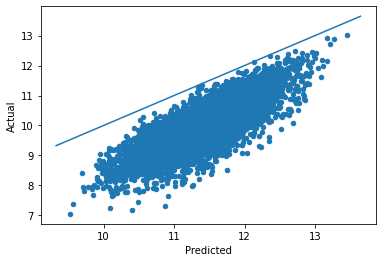

In [55]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm

xbar = np.exp(result.y).sum(['m','i']).to_dataframe('xbar').replace(0,np.nan).squeeze()
xhat = result.get_predicted_expenditures().sum(['m','i']).to_dataframe('xhat').replace(0,np.nan).squeeze()

# Make dataframe of actual & predicted
df = pd.DataFrame({'Actual':np.log(xbar),'Predicted':np.log(xhat)})

df.plot.scatter(x='Predicted',y='Actual')

# Add 45 degree line
v = plt.axis()
vmin = np.max([v[0],v[2]])
vmax = np.max([v[1],v[3]])
plt.plot([vmin,vmax],[vmin,vmax])

#alpha + deltas * vector of children (number of children), for diff in demand

### Household Consumption for Families with Children vs. Families Without

In [56]:
total_expend = result.get_predicted_expenditures().to_dataframe("x").unstack("i").reset_index()

In [57]:
total_expend.iloc[0]

   i                                 
j                                        1.013000e+09
t                                        2.005000e+03
m                                        1.000000e+00
x  beans dry                             1.347326e+03
   beans fresh                           1.252840e+03
   beef                                  3.931643e+03
   bread                                 1.770543e+03
   cabbages                              6.689727e+02
   cassava dry/flour                     1.137720e+03
   cassava fresh                         1.481795e+03
   chicken                               5.416226e+03
   coffee                                4.472961e+02
   cooking oil                           1.092020e+03
   dodo                                  7.235898e+02
   dry/smoked fish                       1.646834e+03
   eggs                                  1.008052e+03
   expenditure in restaurants on food    8.229527e+03
   fresh fish                            2.5

In [58]:
with_children_df

,,,M 0-3,M 4-8,M 9-13,M 14-18,M 19-30,M 31-50,M 51+,F 0-3,F 4-8,F 9-13,F 14-18,F 19-30,F 31-50,F 51+,Family Size
j,t,m,,,,,,,,,,,,,,,
1013000202,2005,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0.693147
1013000210,2005,1,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1.386294
1013000213,2005,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1.098612
1021000113,2005,1,1,1,1,1,0,1,0,0,1,2,1,1,1,0,2.397895
1021000203,2005,1,1,1,1,1,0,0,1,0,0,0,0,2,0,1,2.079442
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2233002609,2011,1,0,0,0,0,1,1,0,0,0,0,1,0,0,2,1.609438
3183000309,2011,1,0,0,0,0,1,0,0,0,0,0,2,0,0,1,1.386294
4171000802,2011,1,0,0,0,0,1,1,0,0,0,0,1,1,1,1,1.791759


In [59]:
without_children_df

,,,M 0-3,M 4-8,M 9-13,M 14-18,M 19-30,M 31-50,M 51+,F 0-3,F 4-8,F 9-13,F 14-18,F 19-30,F 31-50,F 51+,Family Size
j,t,m,,,,,,,,,,,,,,,
1013000201,2005,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.000000
1013000204,2005,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0.000000
1013000206,2005,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0.000000
1013000209,2005,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.000000
1021000103,2005,1,0,0,0,0,3,0,0,0,0,0,0,0,0,0,1.098612
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3010630003050502,2011,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0.000000
3010730012030203,2011,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,1.098612
3010730016100203,2011,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0.693147


In [60]:
with_1 = pd.merge(with_children_df.reset_index()[["j"]], total_expend,  on= "j", how ="inner")

#with_1.iloc[:,[1]] = with_1.iloc[:,[1]].astype(int)

with_1
# make column that gets the average of all the food items that a family consumed that year

/opt/conda/lib/python3.8/site-packages/pandas/core/reshape/merge.py:648: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.8/site-packages/pandas/core/generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


,j,"(t, )","(m, )","(x, beans dry)","(x, beans fresh)","(x, beef)","(x, bread)","(x, cabbages)","(x, cassava dry/flour)","(x, cassava fresh)",...,"(x, other vegetables)","(x, passion fruits)","(x, rice)","(x, salt)","(x, soda)","(x, sugar)","(x, sweet bananas)","(x, sweet potatoes fresh)","(x, tea)","(x, tomatoes)"
0,1013000202,2005,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1013000202,2009,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1013000202,2010,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1013000202,2011,1,2835.478610,2625.727817,6091.767293,2434.177452,942.833830,4657.758145,2546.646047,...,939.058781,1380.611716,3317.696610,226.946941,2520.360585,2780.482560,1354.320455,2474.580928,224.274997,1000.820833
4,1013000210,2005,1,1524.518706,1140.995853,4079.793605,1857.059406,693.364469,3011.578437,1281.601546,...,587.399310,1193.572041,2260.588728,130.165598,2372.981660,2255.431193,843.608931,1725.683181,201.128195,822.693592
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26107,1021001301,2011,1,8033.633244,13707.589816,28366.282122,19593.892528,3013.678398,8296.535193,6206.237133,...,3589.929948,10866.238235,14731.845169,434.571898,13421.671441,15099.080546,9917.963959,6262.088025,896.323782,5339.917690
26108,104300060303,2005,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26109,104300060303,2009,1,2743.572768,2271.444564,7653.436068,4196.442884,1058.746370,2862.463693,2294.553195,...,1484.189253,2202.678688,3978.302764,243.711073,3467.186917,3720.271353,2251.877087,2276.354455,263.899345,1791.948633
26110,104300060303,2010,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [61]:
pd.merge(without_children_df.reset_index()[["j"]], total_expend,on="j" ,how ="inner")

/opt/conda/lib/python3.8/site-packages/pandas/core/reshape/merge.py:648: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.8/site-packages/pandas/core/generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


,j,"(t, )","(m, )","(x, beans dry)","(x, beans fresh)","(x, beef)","(x, bread)","(x, cabbages)","(x, cassava dry/flour)","(x, cassava fresh)",...,"(x, other vegetables)","(x, passion fruits)","(x, rice)","(x, salt)","(x, soda)","(x, sugar)","(x, sweet bananas)","(x, sweet potatoes fresh)","(x, tea)","(x, tomatoes)"
0,1013000201,2005,1,1347.325862,1252.840476,3931.643351,1770.543091,668.972730,1137.719813,1481.794747,...,719.619966,1560.732074,1610.759027,98.752098,2217.849049,2028.508738,1189.514277,1206.630921,210.901157,963.755460
1,1013000201,2009,1,2941.577112,1826.326634,6283.978565,2410.627590,887.273204,5549.730549,2652.131474,...,882.557735,1410.339329,3604.391122,278.669449,2277.422133,3128.528561,1067.350554,3126.751733,211.276581,1029.057252
2,1013000201,2010,1,4247.637384,2564.279363,8182.003097,3131.468446,1267.128542,6369.775998,3324.379715,...,1085.453309,1679.106719,4473.955567,283.040765,3361.430120,4434.159477,1598.439518,4199.859386,239.028297,1310.625589
3,1013000201,2011,1,3801.373081,2878.787632,7640.090284,2716.748316,1172.643597,8438.833955,3749.873222,...,1049.098594,1600.871446,4470.685736,296.385135,3072.738219,3539.351166,1447.584069,3728.119597,251.557125,1115.110060
4,1013000201,2005,1,1347.325862,1252.840476,3931.643351,1770.543091,668.972730,1137.719813,1481.794747,...,719.619966,1560.732074,1610.759027,98.752098,2217.849049,2028.508738,1189.514277,1206.630921,210.901157,963.755460
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20519,3030230010040204,2011,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20520,30211230006050302,2005,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20521,30211230006050302,2009,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20522,30211230006050302,2010,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
